In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                },2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
               
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                },}
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    x_train_mean = []
    x_train_std = []
    x_train_max_min = []
    x_train_main = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_mean = StandardScaler()
    scaler_std = StandardScaler()
    scaler_max_min = StandardScaler()
    scaler_main = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        x_train_main.extend(x)
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        # print(0)
        x_train_mean.extend(jnp.mean(x, axis=1))
        # print(0)
        x_train_std.extend(jnp.std(x, axis=1))
        x_train_max_min.extend(jnp.max(x, axis=1)-jnp.min(x,axis=1))
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train_main = jnp.array(x_train_main).reshape(-1,1)
    x_train_mean = jnp.array(x_train_mean).reshape(-1,1)
    x_train_std =  jnp.array(x_train_std).reshape(-1,1)
    x_train_max_min =  jnp.array(x_train_max_min).reshape(-1,1)


    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_main = scaler_main.fit_transform(x_train_main)
    x_train_mean = scaler_mean.fit_transform(x_train_mean)
    x_train_std = scaler_std.fit_transform(x_train_std)
    x_train_max_min = scaler_max_min.fit_transform(x_train_max_min)

    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_mean = []
    x_test_std = []
    x_test_max_min = []
    x_test_timestamp_true =[]
    x_test_main = []

    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values 
        x_test_main.extend(x)
        y = df[appliances[0]].values
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])

        x_test_mean.extend(jnp.mean(x, axis=1))
        x_test_std.extend(jnp.std(x, axis=1))
        x_test_max_min.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_main = jnp.array(x_test_main).reshape(-1,1)
    x_test_mean = jnp.array(x_test_mean).reshape(-1,1)
    x_test_std =  jnp.array(x_test_std).reshape(-1,1)
    x_test_max_min =  jnp.array(x_test_max_min).reshape(-1,1)


    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_mean = scaler_mean.transform(x_test_mean)
    x_test_std = scaler_std.transform(x_test_std)
    x_test_max_min = scaler_max_min.transform(x_test_max_min)
    x_test_main = scaler_main.transform(x_test_main)
#     y_test = scaler_y.transform(y_test)

    x_train_features = jnp.concatenate((x_train_main, x_train_mean, x_train_std, x_train_max_min), axis=1).reshape(x_train.shape[0], 4)
    x_test_features = jnp.concatenate((x_test_main, x_test_mean, x_test_std, x_test_max_min), axis=1).reshape(x_test.shape[0], 4)

    # x_test_features = x_test_main
    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    scalers = np.array([scaler_x, scaler_y, scaler_time, scaler_main, scaler_mean, scaler_std, scaler_max_min])
    return x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timestamp, x_test_timestamp, scalers, x_test_main


In [6]:
x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timstamp, x_test_timestamp, scalers, x_test_main = dataset_load(appliances, train, test)

In [7]:
scalers

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler()], dtype=object)

In [8]:
# x_train_dif= scalers[-1].inverse_transform(x_train_features[:,-1].reshape(-1,1))
# x_test_dif = scalers[-1].inverse_transform(x_test_features[:,-1].reshape(-1,1))

In [9]:
x1 =  scalers[3].inverse_transform(x_train_features[:,0].reshape(-1,1))
x2 =  scalers[3].inverse_transform(x_test_features[:,0].reshape(-1,1))

In [10]:
x_tr_mean = scalers[4].inverse_transform(x_train_features[:,1].reshape(-1,1))
x_tes_mean = scalers[4].inverse_transform(x_test_features[:,1].reshape(-1,1))

In [11]:
x_tr_std = scalers[5].inverse_transform(x_train_features[:,2].reshape(-1,1))
x_tes_std = scalers[5].inverse_transform(x_test_features[:,2].reshape(-1,1))

In [12]:
x_tr_max_min = scalers[6].inverse_transform(x_train_features[:,3].reshape(-1,1))
x_tes_max_min = scalers[6].inverse_transform(x_test_features[:,3].reshape(-1,1))

In [13]:
y_train1 = scalers[1].inverse_transform(y_train.reshape(-1,1))
y_test1 = y_test

In [14]:
val, count= np.unique(x1, return_counts=True)
val , count

val

array([   36.09532 ,    36.120834,    36.15367 , ..., 10462.48    ,
       11042.472   , 11615.945   ], dtype=float32)

In [15]:
x1.min(), x1.max(), y_train1.min(), y_train1.max(), x2.min(), x2.max(), y_test1.min(), y_test1.max()

(36.09532,
 11615.945,
 4.4086485e-07,
 598.1875,
 160.34183,
 3999.0698,
 DeviceArray(0., dtype=float32),
 DeviceArray(471.61905, dtype=float32))

94.0645

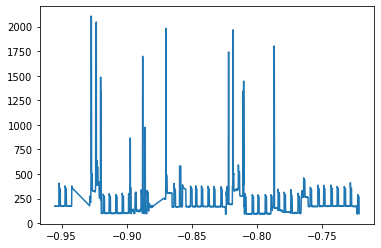

In [16]:
start_ind = 0
add_ind = 3000
plt.plot(x_train_timstamp[start_ind: start_ind + add_ind], x1[start_ind: start_ind + add_ind], label = "Main")
x1[start_ind: start_ind + add_ind].min()

162.59666

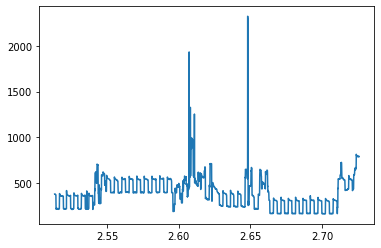

In [17]:
start_ind = 0
add_ind = 3000
plt.plot(x_test_timestamp[start_ind: start_ind + add_ind], x2[start_ind: start_ind + add_ind], label = "Main")
x2[start_ind: start_ind + add_ind].min()

(16780, 1) (16780, 1)


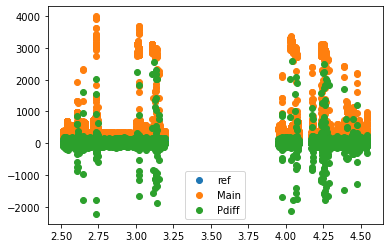

In [18]:
index= x2.shape[0]
start = 1
plt.scatter(x_test_timestamp[start:start+index], y_test1[start:start+index], label = "ref")
plt.scatter(x_test_timestamp[start:start+index], x2[start:start+index], label = "Main")
# plt.scatter(x_test_timestamp[:index], y_train1[:index], label = "Main")
x2[:index].min()

xdiff =  np.array(x2[start:start+index] - x2[start-1:start+index-2])
plt.scatter(x_test_timestamp[start:start+index], xdiff, label="Pdiff")
print(xdiff.shape, x2[start:start+index].shape)

plt.legend()


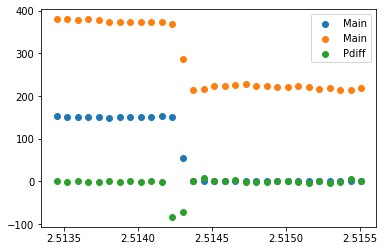

In [19]:
index= 30
start = 1
plt.scatter(x_test_timestamp[start:start+index], y_test1[start:start+index], label = "Main")
plt.scatter(x_test_timestamp[start:start+index], x2[start:start+index], label = "Main")
# plt.scatter(x_test_timestamp[:index], y_train1[:index], label = "Main")
x2[:index].min()

plt.scatter(x_test_timestamp[start:start+index], x2[start+1:start+index+1] - x2[start:start+index], label = "Pdiff")
plt.legend()

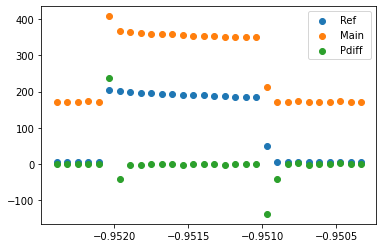

In [20]:
index= 30#x1.shape[0]
start = 40
plt.scatter(x_train_timstamp[start:start+index], y_train1[start:start+index], label = "Ref")
plt.scatter(x_train_timstamp[start:start+index], x1[start:start+index], label = "Main ")
# plt.scatter(x_train_timestamp[:index], y_train1[:index], label = "Main")
x2[:index].min()

diff = np.array(x1)
for i in range(1, len(x1)):
		value = x1[i] - x1[i - 1]
		diff[i] = value
# plt.ylim(-0,400)
plt.scatter(x_train_timstamp[start:start+index], diff[start:start+index], label= "Pdiff")
plt.legend()

(array([5.251e+04, 6.840e+02, 2.540e+02, 8.000e+00]),
 array([   36.09532,  2931.0579 ,  5826.0205 ,  8720.982  , 11615.945  ],
       dtype=float32),
 <BarContainer object of 4 artists>)

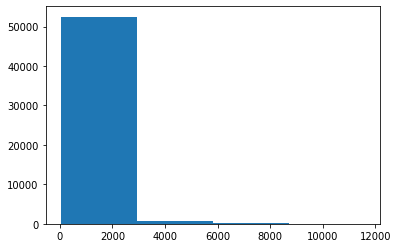

In [21]:
plt.hist(x1,4)

(array([4.0313e+04, 1.2631e+04, 4.7700e+02, 3.5000e+01]),
 array([4.4086485e-07, 1.4954688e+02, 2.9909375e+02, 4.4864062e+02,
        5.9818750e+02], dtype=float32),
 <BarContainer object of 4 artists>)

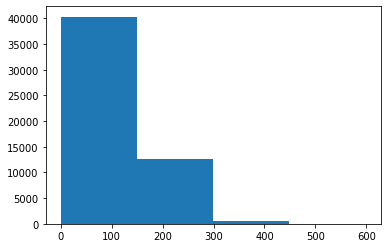

In [22]:
plt.hist(y_train1, 4)

(array([15742.,    93.,   683.,   263.]),
 array([ 160.34183, 1120.0238 , 2079.7058 , 3039.388  , 3999.0698 ],
       dtype=float32),
 <BarContainer object of 4 artists>)

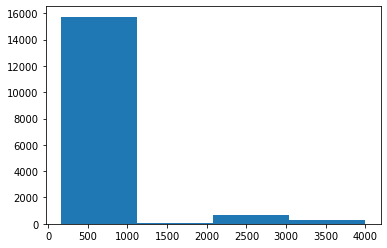

In [23]:
plt.hist(x2,4)


(array([49121.,  2664.,  1546.,   125.]),
 array([7.3245468e+00, 2.8660352e+03, 5.7247456e+03, 8.5834561e+03,
        1.1442167e+04], dtype=float32),
 <BarContainer object of 4 artists>)

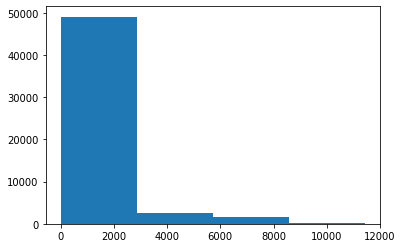

In [24]:
plt.hist(x_tr_max_min,4)

(array([13660.,   366.,  2290.,   465.]),
 array([ 153.5685, 1064.3217, 1975.0748, 2885.828 , 3796.581 ],
       dtype=float32),
 <BarContainer object of 4 artists>)

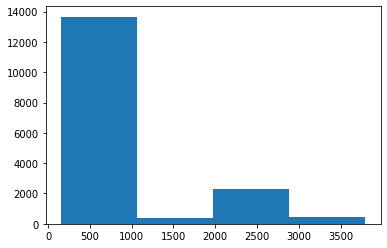

In [25]:
plt.hist(x_tes_max_min,4)

(array([15067.,   896.,   506.,   312.]),
 array([ 136.48022,  895.71545, 1654.9507 , 2414.186  , 3173.4211 ],
       dtype=float32),
 <BarContainer object of 4 artists>)

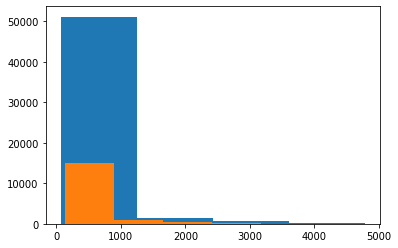

In [26]:
plt.hist(x_tr_mean,4)
plt.hist(x_tes_mean,4)

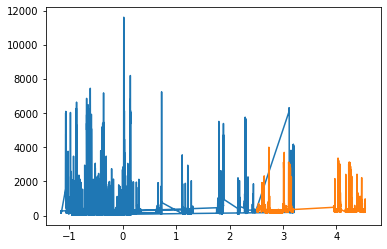

In [27]:
plt.plot(x_train_timstamp[:], x1[:], label = "Main")
plt.plot(x_test_timestamp[:], x2[:], label = "Main")

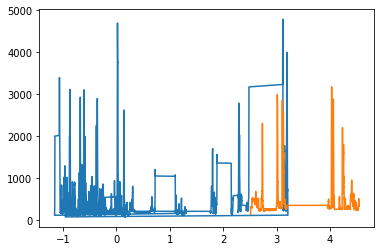

In [28]:
plt.plot(x_train_timstamp[:], x_tr_mean[:], label="Main Mean")
plt.plot(x_test_timestamp[:], x_tes_mean[:], label="Main Mean")

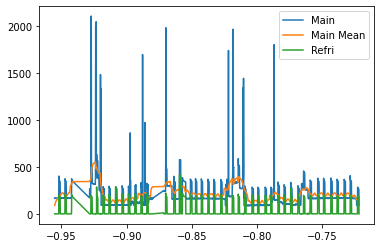

In [29]:
idx = 3000
plt.plot(x_train_timstamp[:idx], x1[:idx], label = "Main")
plt.plot(x_train_timstamp[:idx], x_tr_mean[:idx], label="Main Mean")
# plt.plot(x_train_timestamp[:idx], x_tr_std[:idx], label="Main std")
# plt.plot(x_train_timestamp[:idx], x_tr_max_min[:idx], label="Main Max_Min")
plt.plot(x_train_timstamp[:idx], scalers[1].inverse_transform(y_train.reshape(-1,1))[:idx], label = "Refri")
plt.legend()

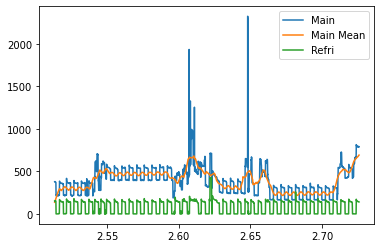

In [46]:
idx = 3000
plt.plot(x_test_timestamp[:idx], x2[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], x_tes_mean[:idx], label="Main Mean")
# plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")
plt.legend()

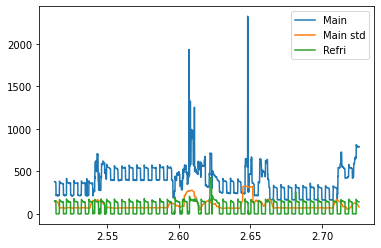

In [30]:
idx = 3000
plt.plot(x_test_timestamp[:idx], x2[:idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], x_tes_mean[:idx], label="Main Mean")
plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")
plt.legend()

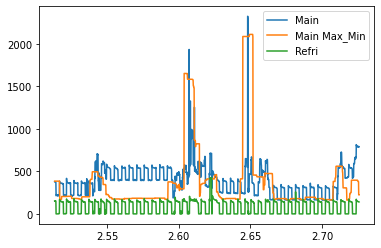

In [31]:
idx = 3000
plt.plot(x_test_timestamp[:idx], x2[:idx], label = "Main")
# plt.plot(x_test_timestamp[:idx], x_tes_mean[:idx], label="Main Mean")
# plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
plt.plot(x_test_timestamp[:idx], x_tes_max_min[:idx], label="Main Max_Min")
plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")
plt.legend()

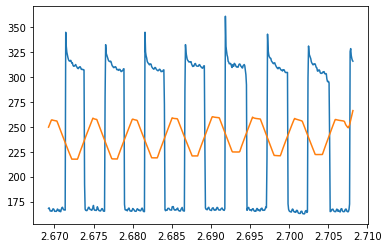

In [32]:
idx = 2750
plt.plot(x_test_timestamp[2200:idx], x2[2200:idx], label = "Main")
plt.plot(x_test_timestamp[2200:idx], x_tes_mean[2200:idx], label="Main Mean")
# plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
# plt.plot(x_test_timestamp[:idx], x_tes_max_min[:idx], label="Main Max_Min")
# plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")

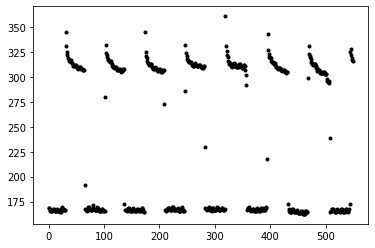

In [33]:
plt.plot( x2[2200:idx], 'k.')

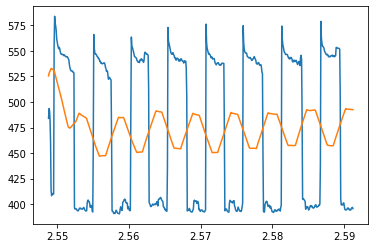

In [34]:
idx = 1100
plt.plot(x_test_timestamp[500:idx], x2[500:idx], label = "Main")
plt.plot(x_test_timestamp[500:idx], x_tes_mean[500:idx], label="Main Mean")

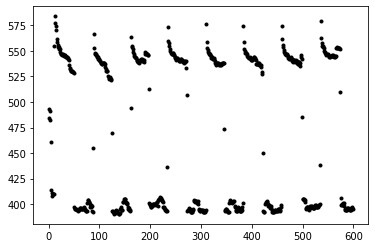

In [35]:
plt.plot(x2[500:idx], 'k.')

In [36]:
x2[2200:2750].max() - x2[2200:2750].min(), x2[500:1100].max() - x2[500:1100].min()

(198.28151, 193.65286)

In [37]:
min_val = x2[500:1100].min() - x2[2200:2750].min() 
min_val

227.74577

In [38]:
x2_mod = x2[500:1100] - min_val

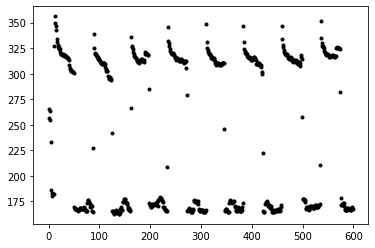

In [39]:
plt.plot(x2_mod,'k.')

<Figure size 432x288 with 0 Axes>

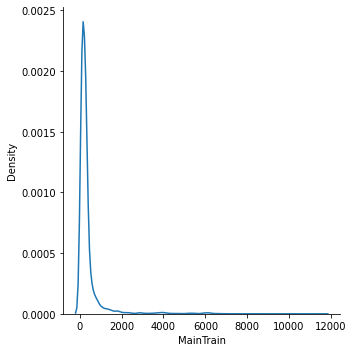

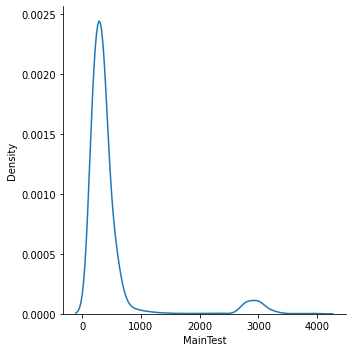

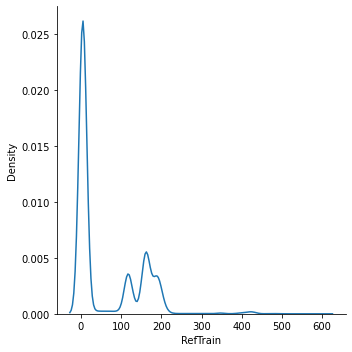

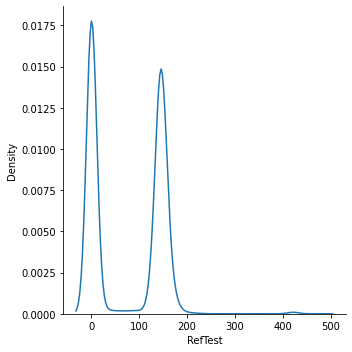

In [40]:
x1_plot = pd.DataFrame(x1.reshape(-1,), columns=["MainTrain"])
x2_plot = pd.DataFrame(x2.reshape(-1,), columns=["MainTest"])
y1_plot = pd.DataFrame(y_train1.reshape(-1,), columns=["RefTrain"])
y2_plot = pd.DataFrame(y_test1.reshape(-1,), columns=["RefTest"])

x3 = np.zeros(len(x1))
x3[0:len(x2)] = x2.reshape(-1,)
data={"0":x1.reshape(-1,), "1":y_train1.reshape(-1,)}
x_plot = pd.DataFrame(data=data)
# sns.displot(x_plot,kind="kde", fill=True)

plt.figure()
sns.displot(x1_plot,x="MainTrain", kind="kde")
sns.displot(x2_plot,x="MainTest",kind="kde")
sns.displot(y1_plot,x="RefTrain",kind="kde")
sns.displot(y2_plot,x="RefTest",kind="kde")
plt.show()

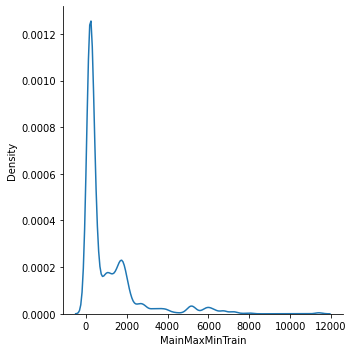

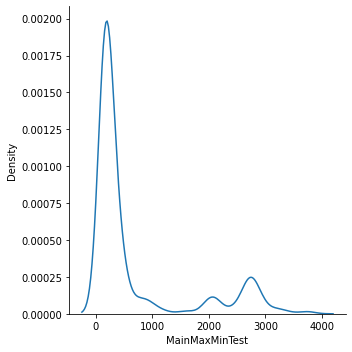

In [41]:
x1_plot = pd.DataFrame(x_tr_max_min.reshape(-1,), columns=["MainMaxMinTrain"])
x2_plot = pd.DataFrame(x_tes_max_min.reshape(-1,), columns=["MainMaxMinTest"])



sns.displot(x1_plot,x="MainMaxMinTrain", kind="kde")
sns.displot(x2_plot,x="MainMaxMinTest",kind="kde")

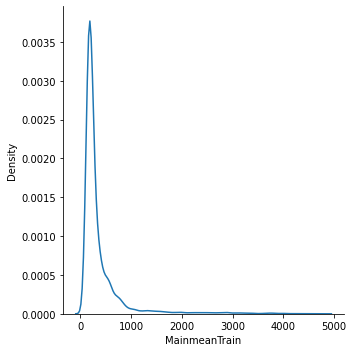

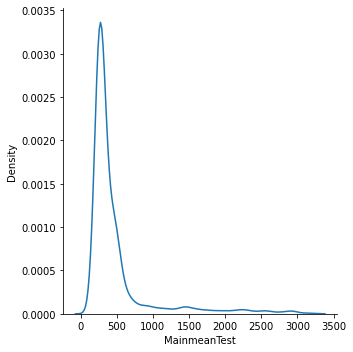

In [42]:
x1_plot = pd.DataFrame(x_tr_mean.reshape(-1,), columns=["MainmeanTrain"])
x2_plot = pd.DataFrame(x_tes_mean.reshape(-1,), columns=["MainmeanTest"])



sns.displot(x1_plot,x="MainmeanTrain", kind="kde")
sns.displot(x2_plot,x="MainmeanTest",kind="kde")

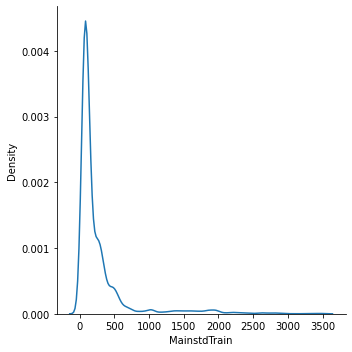

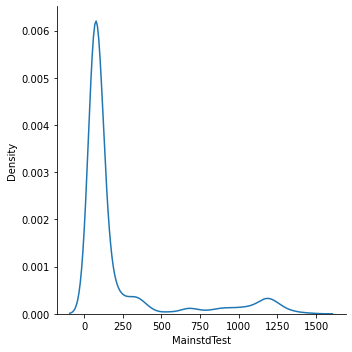

In [43]:
x1_plot = pd.DataFrame(x_tr_std.reshape(-1,), columns=["MainstdTrain"])
x2_plot = pd.DataFrame(x_tes_std.reshape(-1,), columns=["MainstdTest"])



sns.displot(x1_plot,x="MainstdTrain", kind="kde")
sns.displot(x2_plot,x="MainstdTest",kind="kde")

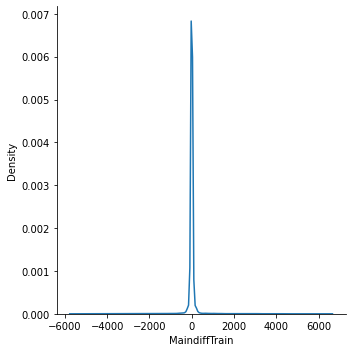

In [44]:
x_diff = np.zeros(x1.shape)
x_diff[0] = x1[0]
for i in range(1, len(x_diff)):
  x_diff[i] = x1[i] -  x1[i-1]

x1_plot = pd.DataFrame(x_diff.reshape(-1,), columns=["MaindiffTrain"])
sns.displot(x1_plot,x="MaindiffTrain", kind="kde")

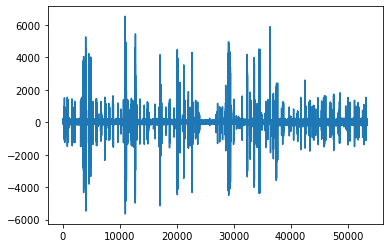

In [45]:
plt.plot(x_diff)